# load dataset

In [1]:
import configparser
import logging
from ocs_sample_library_preview import *
import json

config = configparser.ConfigParser()
config.read('config.ini')

ocsClient = OCSClient(config.get('Access', 'ApiVersion'), config.get('Access', 'Tenant'), config.get('Access', 'Resource'), 
                        config.get('Credentials', 'ClientId'), config.get('Credentials', 'ClientSecret'))
        

namespace_id = config.get('Configurations', 'Namespace')

In [9]:
# Common imports
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
from tensorflow import set_random_seed

from keras.layers import Input, Dropout
from keras.layers.core import Dense 
from keras.models import Model, Sequential, load_model
from keras import regularizers
from keras.models import model_from_json

#Errors can be ignored if they relate to tensorflow - not used for this exercise

ModuleNotFoundError: No module named 'tensorflow'

#load dataset from OCS - this step takes time!

In [6]:
import pandas as pd
import numpy as np
import datetime

#result = ocsClient.Streams.getRangeValues(namespace_id,"nasa.bearing1",start="2004-02-12T10:52:39",skip=0,count=20480,value_class=None,reverse=False,boundary_type=SdsBoundaryType.Inside)
from decimal import Decimal
ocsClient.acceptverbosity=True

merged_data = pd.DataFrame()
df_values = pd.DataFrame()
pd.options.display.float_format = '{:.3}'.format
pd.options.display.float_format = None

# start of data collection
signal_datetime = (datetime.datetime.strptime("2004-02-12T10:32:39","%Y-%m-%dT%H:%M:%S"))
# for each data collection cycle
for _ in range(1,985):
    #print(signal_datetime)
    signal_means = pd.Series(name=signal_datetime.isoformat())
    # Each bearing for a cycle
    for bearing in range(1,5):
        values = ocsClient.Streams.getRangeValues(namespace_id,f'nasa.bearing{bearing}',start=signal_datetime,skip=0,count=20480,value_class=None,reverse=False,boundary_type=SdsBoundaryType.Exact)
        df_result = pd.DataFrame.from_dict(values)
        signal_means[f'bearing {bearing}'] = round(df_result['channel'].astype(np.float32).abs().mean(),6)
        #signal_means[f'bearing {bearing}'] = np.array(df_result['channel'].astype(np.float32).abs()).mean()
    merged_data = merged_data.append(signal_means)
    signal_datetime += datetime.timedelta(minutes=10)
merged_data.shape
#df_values.to_csv(sep='\t',path_or_buf='records_mean.csv',columns=['bearing 1','bearing 2','bearing 3','bearing 4'],index_label=None,index=None,header=None,float_format='%.3f')


(984, 4)

# split dataset for testing and training

In [7]:
dataset_train = merged_data['2004-02-12 11:02:39':'2004-02-13 23:52:39']
dataset_test = merged_data['2004-02-13 23:52:39':]
dataset_train.plot(figsize = (12,6))
dataset_test.plot(figsize = (12,6))

# normalize data

In [10]:
scaler = preprocessing.MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(dataset_train), 
                              columns=dataset_train.columns, 
                              index=dataset_train.index)
# Random shuffle training data
X_train.sample(frac=1)

X_test = pd.DataFrame(scaler.transform(dataset_test), 
                             columns=dataset_test.columns, 
                             index=dataset_test.index)

# compress sensor data down to two principal components

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, svd_solver= 'full')

X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(X_train_PCA)
X_train_PCA.index = X_train.index

X_test_PCA = pca.transform(X_test)
X_test_PCA = pd.DataFrame(X_test_PCA)
X_test_PCA.index = X_test.index

In [12]:
# 
data_train = np.array(X_train_PCA.values)
data_test = np.array(X_test_PCA.values)

In [13]:
def cov_matrix(data, verbose=False):
    covariance_matrix = np.cov(data, rowvar=False)
    if is_pos_def(covariance_matrix):
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        if is_pos_def(inv_covariance_matrix):
            return covariance_matrix, inv_covariance_matrix
        else:
            print("Error: Inverse of Covariance Matrix is not positive definite!")
    else:
        print("Error: Covariance Matrix is not positive definite!")
        
def MahalanobisDist(inv_cov_matrix, mean_distr, data, verbose=False):
    inv_covariance_matrix = inv_cov_matrix
    vars_mean = mean_distr
    diff = data - vars_mean
    md = []
    for i in range(len(diff)):
        md.append(np.sqrt(diff[i].dot(inv_covariance_matrix).dot(diff[i])))
    return md

def MD_detectOutliers(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    outliers = []
    for i in range(len(dist)):
        if dist[i] >= threshold:
            outliers.append(i)  # index of the outlier
    return np.array(outliers)

def MD_threshold(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    return threshold

def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

In [14]:

cov_matrix, inv_cov_matrix  = cov_matrix(data_train)
mean_distr = data_train.mean(axis=0)
dist_test = MahalanobisDist(inv_cov_matrix, mean_distr, data_test, verbose=False)
dist_train = MahalanobisDist(inv_cov_matrix, mean_distr, data_train, verbose=False)
threshold = MD_threshold(dist_train, extreme = True)


# visualizing the square of the Mahalanobis distance

(0.0, 15)

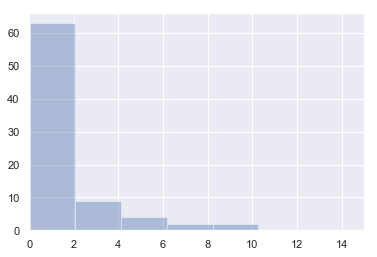

In [15]:
custom_style = {'axes.labelcolor': 'white',
                'xtick.color': 'white',
                'ytick.color': 'white',
                'grid.color': 'white',
                'axes.edgecolor': 'black',
                'axes.facecolor': '#EAEAF2'}
#custom_style = {'axes.edgecolor': 'white',
# 'axes.facecolor': '#EAEAF2',
# 'axes.labelcolor': '.15',
# 'grid.color': 'white',
# 'text.color': '.15',
# 'xtick.color': '.15',
# 'ytick.color': '.15'}
plt.figure()
sns.distplot(np.square(dist_train),
             bins = 10, 
             kde= False);
sns.set_style("darkgrid",rc=custom_style)
sns.reset_defaults()
#sns.reset_orig()
#,rc=custom_style)
sns.set_style("whitegrid")
plt.xlim([0.0,15])

# Mahalanobis distance

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,0,'Mahalanobis dist')

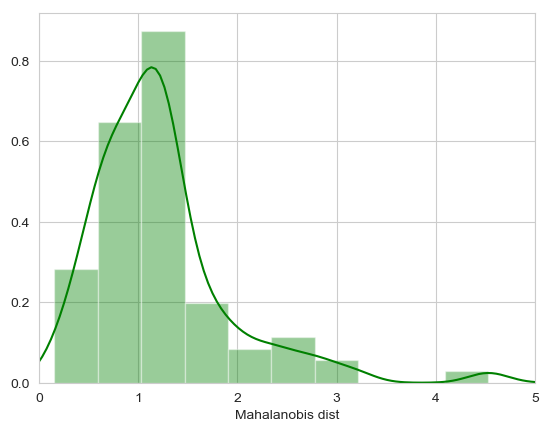

In [16]:
plt.figure()
sns.distplot(dist_train,
             bins = 10, 
             kde= True, 
            color = 'green');
plt.xlim([0.0,5])
plt.xlabel('Mahalanobis dist')

In [17]:
anomaly_train = pd.DataFrame()
anomaly_train['Mob dist']= dist_train
anomaly_train['Thresh'] = threshold
# If Mob dist above threshold: Flag as anomaly
anomaly_train['Anomaly'] = anomaly_train['Mob dist'] > anomaly_train['Thresh']
anomaly_train.index = X_train_PCA.index

anomaly = pd.DataFrame()
anomaly['Mob dist']= dist_test
anomaly['Thresh'] = threshold
# If Mob dist above threshold: Flag as anomaly
anomaly['Anomaly'] = anomaly['Mob dist'] > anomaly['Thresh']
anomaly.index = X_test_PCA.index
anomaly.head()

Mob dist    Thresh  Anomaly
2004-02-13T00:02:39  0.823103  3.654352    False
2004-02-13T00:12:39  0.786549  3.654352    False
2004-02-13T00:22:39  1.129855  3.654352    False
2004-02-13T00:32:39  2.336024  3.654352    False
2004-02-13T00:42:39  0.871648  3.654352    False

In [18]:
anomaly_alldata = pd.concat([anomaly_train, anomaly])
anomaly_alldata.to_csv('Anomaly_distance.csv')

In [19]:
anomaly_alldata.plot(logy=True, figsize = (10,6), ylim = [1e-1,1e3], color = ['green','red'])